In [1]:
%load_ext autoreload
import sys
sys.path.append('../.')
from cppn import *
from util import visualize_network
import numpy as np
import torch
import matplotlib.pyplot as plt
import imageio as iio

%matplotlib inline

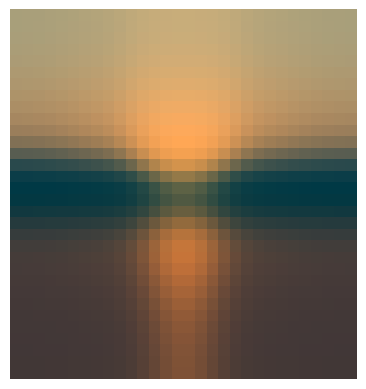

In [2]:
with open("sunrise.json") as f:
    net_json = json.load(f)
    net = CPPN.create_from_json(net_json, configClass=Config)
img = net.get_image()
plt.imshow(img); plt.axis('off'); plt.show()
net.prepare_optimizer(lr=.001)

In [3]:
target=torch.tensor(iio.imread('../../data/sunrise/sunrise.png'), dtype=torch.float32) / 255.0
net.config.res_h, net.config.res_w = target.shape[:2]
net.reconfig()
print("target shape:", target.shape)

target shape: torch.Size([342, 319, 3])


In [6]:
from functorch.compile import compiled_function, draw_graph, aot_function

def f():
    return net.get_image_data_parallel() 
    
def fw(f, inps):
    # draw_graph(f, "forward.svg")
    return f
 
def bw(f, inps):
    # draw_graph(f, "backward.svg")
    return f
    
aot_fn = aot_function(f, fw_compiler=fw, bw_compiler=bw)

In [7]:
# plt.imshow(img.detach()); plt.axis('off'); plt.show()
from fitness_functions import *

# loss_fn = torch.nn.MSELoss()
# loss_fn = lambda x,y: 1.0-haarpsi(x,y) 
loss_fn = lambda x,y: 1.0-mse(x,y,keep_grad=True)

imgs = []
from tqdm import trange
pbar = trange(10000)
for _ in pbar:
    img = aot_fn()
    imgs.append(img.detach().numpy())
    img, target = correct_dims(img.unsqueeze(0), target)
    net.optimizer.zero_grad()
    loss = loss_fn(img, target)
    loss.backward()
    net.optimizer.step()
    pbar.set_description(f"Loss: {loss.item():.4f}")



  0%|          | 0/10000 [06:45<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
output = imgs[-1]
plt.imshow(output); plt.axis('off'); plt.show()

In [ ]:
# save gif
imgs = [img * 255 for img in imgs]
imgs = [img.astype(np.uint8) for img in imgs] 
iio.mimsave('backprop.gif', imgs, duration=0.1)